Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Section 12.7.1

Temperature estimation given the day of the year and the hour of the day using regression trees. This is a toy problem (although it uses real temperature data from Manhattan, Kansas), which requires nonlinear estimation\
Topics and relevant videos: [Regression](https://www.youtube.com/watch?v=9ugdj-kLGCI), [regression tree](https://www.youtube.com/watch?v=4cSP8G3t33M)

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from os import listdir
from scipy import stats
import datetime as dt

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

In [70]:
file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"
file_name_temperature_2016 = "../data/weather/temperatures_2016.npy"
file_name_times_2015 = "../data/weather/times_2015.npy"
file_name_times_2016 = "../data/weather/times_2016.npy"
file_name_dates_2015 = "../data/weather/dates_2015.npy"
file_name_dates_2016 = "../data/weather/dates_2016.npy"

data_matrix_2015 = np.load(file_name_temperature_2015)
data_matrix_2016 = np.load(file_name_temperature_2016)
time_matrix_2015 = np.load(file_name_times_2015)
time_matrix_2016 = np.load(file_name_times_2016)
date_matrix_2015 = np.load(file_name_dates_2015)
date_matrix_2016 = np.load(file_name_dates_2016)

file_name_list = np.load('../data/weather/weather_station_names.npy')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [71]:
station = 52 
name = process_name(file_name_list[station]) 
print(name)

Manhattan, KS


In [72]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("Entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = False
temperature_2015 = remove_faulty_measurements(data_matrix_2015[:,station],verbose)
n_2015 = len(temperature_2015)
temperature_2016 = remove_faulty_measurements(data_matrix_2016[:,station],verbose)
n_2016 = len(temperature_2016)

In [73]:
hour_2015 = (time_matrix_2015[:,station]/100).astype(int)
hour_2016 = (time_matrix_2016[:,station]/100).astype(int)

day_2015 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2015[:,station]])
day_2016 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2016[:,station]])

n_data_366 = np.sum(day_2016==366)
temperature_2016 = temperature_2016[:-n_data_366]
day_2016 = day_2016[:-n_data_366]
hour_2016 = hour_2016[:-n_data_366]

In [74]:
n_days = 365
n_hours = 24

temperature_grid_2015 = np.zeros((n_hours,n_days))
temperature_grid_2016 = np.zeros((n_hours,n_days))
for h in np.arange(0,n_hours,1):
    for m in np.arange(1,n_days+1,1):
        temperature_grid_2015[h,m-1] = np.mean(temperature_2015[(hour_2015 == h) & (day_2015 == m)])
        temperature_grid_2016[h,m-1] = np.mean(temperature_2016[(hour_2016 == h) & (day_2016 == m)])
max_mean_temp_2015 = np.max(temperature_grid_2015)
max_mean_temp_2016 = np.max(temperature_grid_2016)
max_mean_temp = np.max(np.array([max_mean_temp_2015,max_mean_temp_2016]))
min_mean_temp_2015 = np.min(temperature_grid_2015)
min_mean_temp_2016 = np.min(temperature_grid_2016)
min_mean_temp = np.min(np.array([min_mean_temp_2015,min_mean_temp_2016]))

In [75]:
# Linear regression model
X = np.array([hour_2015,day_2015]).T
linear_model = LinearRegression().fit(X, temperature_2015)

In [76]:
print("Linear coefficients: " + str(linear_model.coef_))
print("Intercept: " + str(round(linear_model.intercept_,3)))
linear_prediction_2015 = linear_model.predict(X)
rmse_linear_2015 = np.sqrt(np.sum((temperature_2015-linear_prediction_2015)**2)/n_2015)
X_2016 = np.array([hour_2016,day_2016]).T
linear_prediction_2016 = linear_model.predict(X_2016)
rmse_linear_2016 = np.sqrt(np.sum((temperature_2016-linear_prediction_2016)**2)/n_2016)
print("Training RMSE of linear model:",round(rmse_linear_2015,3))
print("Test RMSE of linear model:",round(rmse_linear_2016,3))

Linear coefficients: [0.25  0.028]
Intercept: 5.482
Training RMSE of linear model: 10.809
Test RMSE of linear model: 10.972


In [77]:
linear_prediction_grid = np.zeros((n_hours,n_days))
for h in np.arange(0,n_hours,1):
    for m in np.arange(1,n_days+1,1):
        linear_prediction_grid[h,m-1] = linear_model.predict(np.array([h,m]).reshape(1, -1))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



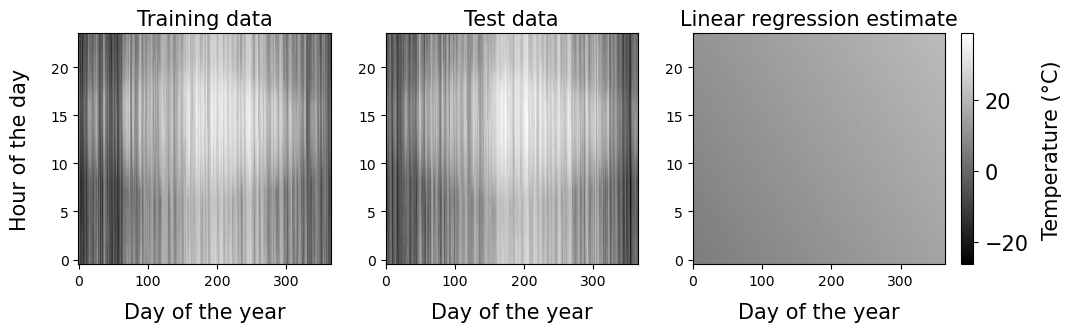

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3),width_ratios=[3,3,3.75])

ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
ax1.set_title("Training data",fontsize=font_size);

ax2.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                origin='lower', aspect='auto')
ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax2.set_title("Test data",fontsize=font_size);

im = ax3.imshow(linear_prediction_grid, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10)
ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
ax3.set_title("Linear regression estimate",fontsize=font_size);

In [79]:
# Returns indices corresponding to region r
def inds_region(r):
    return ( (day_2015 >= r["day_lims"][0]) & (day_2015 <= r["day_lims"][1]) 
                             & (hour_2015 >= r["hour_lims"][0]) & (hour_2015 <= r["hour_lims"][1]) )

# Returns the estimate corresponding to a tree, as well as the residual sum of squared errors with respect to the training and test data 
def tree_estimate(regions,verbose):
    err_2015 = 0
    err_2016 = 0
    n_regions = len(regions)
    estimate_grid = np.zeros((n_hours,n_days))
    for ind_r,r in enumerate(regions):
        inds_region_2015 = inds_region(r)
        temp_region_2015 = temperature_2015[inds_region_2015]
        inds_region_2016 = ( (day_2016 >= r["day_lims"][0]) & (day_2016 <= r["day_lims"][1]) 
                             & (hour_2016 >= r["hour_lims"][0]) & (hour_2016 <= r["hour_lims"][1]) )
        temp_region_2016 = temperature_2016[inds_region_2016]
        est_region = np.mean(temp_region_2015)
        err_2015 = err_2015 + np.sum( (temp_region_2015 - est_region)**2 )
        err_2016 = err_2016 + np.sum( (temp_region_2016 - est_region)**2 )
        estimate_grid[r["hour_lims"][0]:(r["hour_lims"][1]+1),(r["day_lims"][0]-1):r["day_lims"][1]] = est_region
    
    MSE_training = err_2015 / n_2015
    MSE_test = err_2016 / n_2016
    return [MSE_training,MSE_test,estimate_grid]

In [80]:
# Plots regions corresponding to a regression tree superposed onto the training and test data, as well as the regression estimate
def plot_regions(lines,estimate,title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3),width_ratios=[3,3,3.75])
    fig.suptitle(title,fontsize=font_size,y = 1.1)
    
    im = ax1.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
    for line in lines:
        if line[0] == "day":
            ax1.vlines(line[1]-1.5,line[2]-0.5,line[3]+0.5,ls='dashed',color='white',lw=5)
        else:
            ax1.hlines(line[1]-0.5,line[2]-1.5,line[3]-0.5,ls='dashed',color='white',lw=5)
    ax1.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    ax1.set_ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
    ax1.set_ylim([0-0.5,n_hours-0.5])
    ax1.set_xlim([0-0.5,n_days-0.5])
    ax1.set_title("Training data",fontsize=font_size);

    im = ax2.imshow(estimate, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
    ax2.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    ax2.set_title("Tree estimate",fontsize=font_size);
    
    im = ax3.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                        origin='lower', aspect='auto')
    for line in lines:
        if line[0] == "day":
            plt.vlines(line[1]-1.5,line[2]-0.5,line[3]+0.5,ls='dashed',color='white',lw=5)
        else:
            plt.hlines(line[1]-0.5,line[2]-1.5,line[3]-0.5,ls='dashed',color='white',lw=5)
    ax3.set_xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    ax3.set_ylim([0-0.5,n_hours-0.5])
    ax3.set_xlim([0-0.5,n_days-0.5]);
    ax3.set_title("Test data",fontsize=font_size);
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=font_size_ticks,pad = 5)
    cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 10);

In [81]:
# Given a set of possible thresholds for a feature, this function computes the residual sum of squares of the tree estimator 
# within that region for each of the possible thresholds
def find_split(feature,data,possible_thresholds, verbose=True):
    err_vals = np.zeros(len(possible_thresholds))
    best_thresh = 0
    best_err = -1
    for ind,thresh in enumerate(possible_thresholds):
        left_split = data[feature < thresh]
        right_split = data[feature >= thresh]
        estimate_right_split = np.mean(right_split)
        if len(left_split)>0:
            estimate_left_split = np.mean(left_split)
            err_vals[ind] = np.sum((left_split-estimate_left_split)**2) + np.sum((right_split-estimate_right_split)**2)
        else:
            err_vals[ind] = np.sum((right_split-estimate_right_split)**2)
        if verbose:
            print(thresh)
            print("left split: ",len(left_split))
            print("right split: ",len(right_split))
            if len(left_split)>0:
                print("estimate left split: ",estimate_left_split)
            print("estimate right split: ",estimate_right_split)
            print("squared error: ",err_vals[ind])
    return err_vals

First region estimate 13.43
Split 1
Region to split {'day_lims': [1, 365], 'hour_lims': [0, 23]}
Feature day
Threshold 66
New left region {'day_lims': [1, 65], 'hour_lims': [0, 23]}
Estimate -1.37
New right region {'day_lims': [66, 365], 'hour_lims': [0, 23]}
Estimate 16.64
Split 2
Region to split {'day_lims': [66, 365], 'hour_lims': [0, 23]}
Feature day
Threshold 297
New left region {'day_lims': [66, 296], 'hour_lims': [0, 23]}
Estimate 19.62
New right region {'day_lims': [297, 365], 'hour_lims': [0, 23]}
Estimate 6.67
Split 3
Region to split {'day_lims': [66, 296], 'hour_lims': [0, 23]}
Feature day
Threshold 145
New left region {'day_lims': [66, 144], 'hour_lims': [0, 23]}
Estimate 13.75
New right region {'day_lims': [145, 296], 'hour_lims': [0, 23]}
Estimate 22.67
Split 4
Region to split {'day_lims': [145, 296], 'hour_lims': [0, 23]}
Feature hour
Threshold 9
New left region {'day_lims': [145, 296], 'hour_lims': [0, 8]}
Estimate 19.03
New right region {'day_lims': [145, 296], 'hour_l

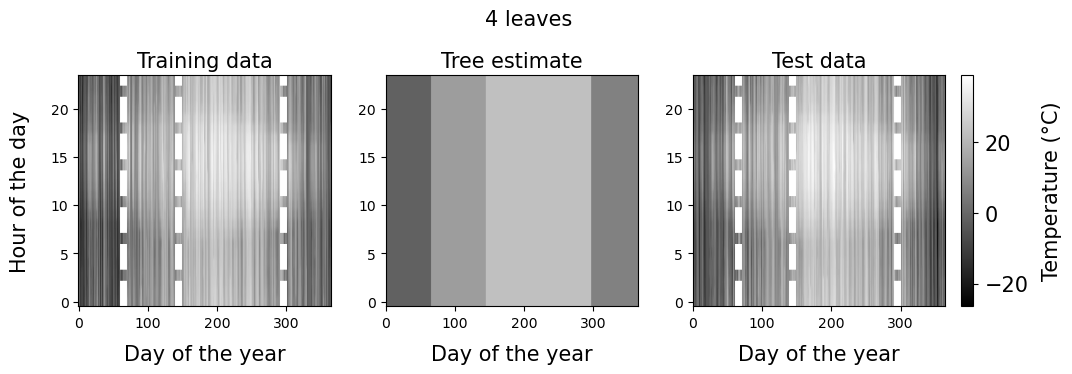

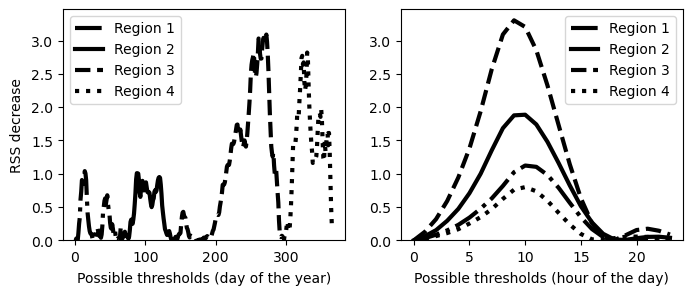

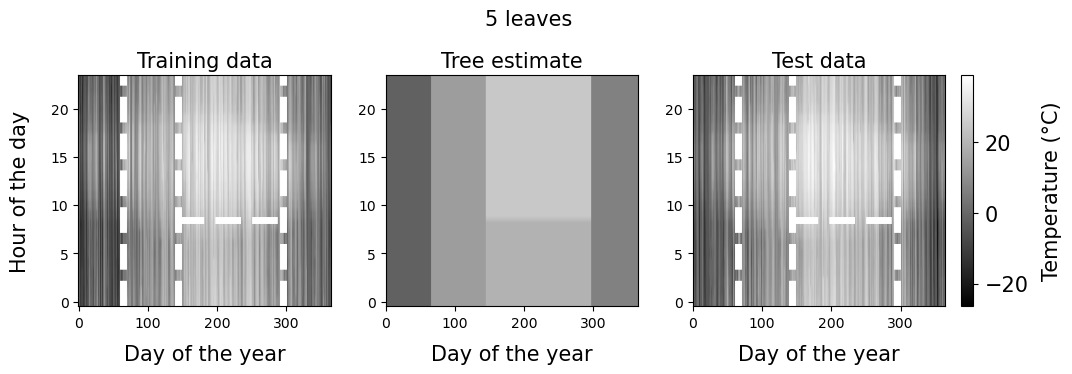

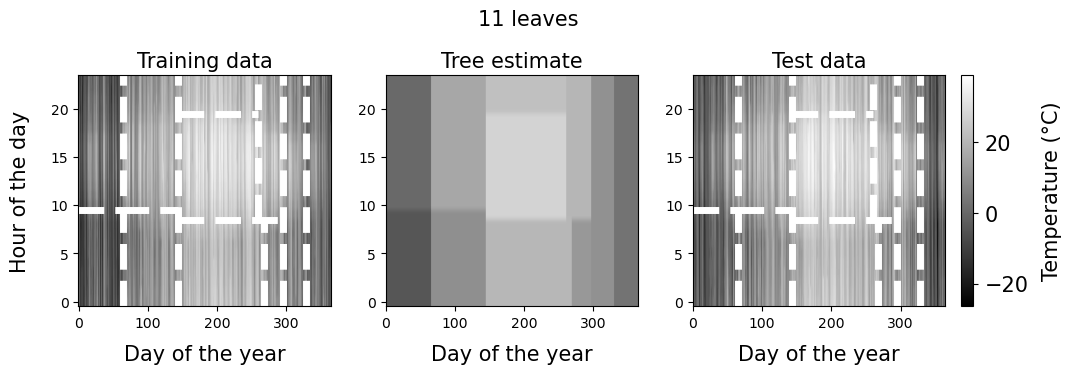

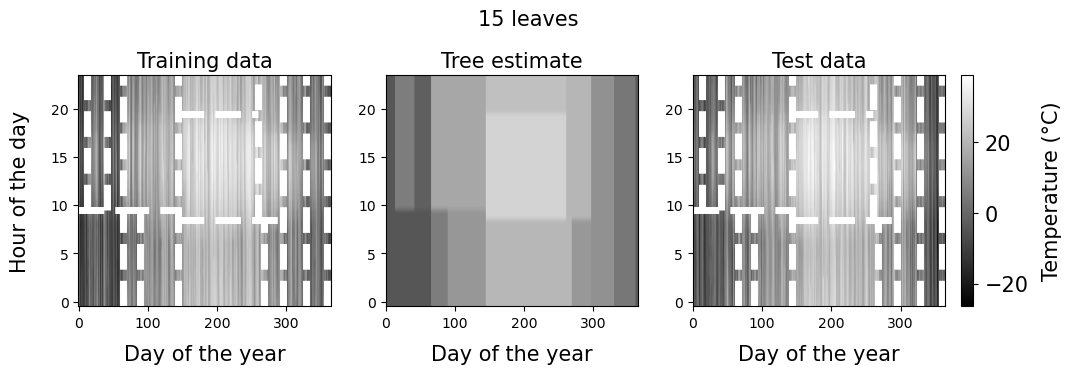

In [82]:
# We construct a regression tree by applying recursive binary splitting based on sample mean squared error
plot_lines = []
# The first region is the whole feature space
first_region = {
  "day_lims": [1,n_days],
  "hour_lims": [0,n_hours-1]
}
regions = [first_region]

verbose = True
if verbose:
    print("First region estimate",round(np.mean(temperature_2015),2))
            
# We perform 19 splits
n_splits = 19
find_split_verbose = False

MSE_2015_splits = np.zeros(n_splits+1)
MSE_2016_splits = np.zeros(n_splits+1)

[MSE_2015,MSE_2016,estimate] = tree_estimate(regions,verbose)

MSE_2015_splits[0] = MSE_2015 
MSE_2016_splits[0] = MSE_2016 

plot_splits = [3] # We plot the possible splits for a 4-leaf tree
plot_tree_estimate = [2,3,9,13]
l_styles = ["dashdot","dotted","solid","dashed"]
plot_ind_regions = [0,2,3,1]

for ind_splits in range(n_splits):
    
    if verbose:
        print("Split",ind_splits+1)
    
    split_region_ind = -1
    split_feature = ""
    split_thresh = -1
    best_err_decrease = 0
    
    if ind_splits in plot_splits:
        plot_split_thresholds_day = []
        plot_MSE_thresholds_day = []
        plot_split_thresholds_hour = []
        plot_MSE_thresholds_hour = []
        
    for ind_r,r in enumerate(regions):
        
        inds_region_2015 = inds_region(r)
        temp_region_2015 = temperature_2015[inds_region_2015]
        day_region_2015 = day_2015[inds_region_2015]
        hour_region_2015 = hour_2015[inds_region_2015]
        err_region = np.sum((temp_region_2015-np.mean(temp_region_2015))**2)
        possible_thresholds_day = np.arange(r["day_lims"][0],r["day_lims"][1]+1)
        err_day = find_split(day_region_2015,temp_region_2015,possible_thresholds_day,find_split_verbose)
        best_err_day_ind = np.argmin(err_day)
        best_err_day = err_day[best_err_day_ind]
        possible_thresholds_hour = np.arange(r["hour_lims"][0],r["hour_lims"][1]+1)
        err_hour = find_split(hour_region_2015,temp_region_2015,possible_thresholds_hour,find_split_verbose)
        best_err_hour_ind = np.argmin(err_hour)
        best_err_hour = err_hour[best_err_hour_ind]
        if ind_splits in plot_splits:
            plot_split_thresholds_day.append(possible_thresholds_day)
            plot_MSE_thresholds_day.append((err_region-err_day)/n_2015)
            plot_split_thresholds_hour.append(possible_thresholds_hour)
            plot_MSE_thresholds_hour.append((err_region-err_hour)/n_2015)
        if best_err_day < best_err_hour:
            feature = "day"
            thresh = possible_thresholds_day[best_err_day_ind]
            err_decrease = err_region-best_err_day
        else:
            feature = "hour"
            thresh = possible_thresholds_hour[best_err_hour_ind]
            err_decrease = err_region-best_err_hour
        if split_region_ind == -1 or err_decrease > best_err_decrease:
            split_region_ind = ind_r
            split_feature = feature
            split_thresh = thresh
            best_err_decrease = err_decrease
    if ind_splits in plot_splits:
        max_MSE_dec = 1.05 * np.max(np.array([np.max(np.concatenate(plot_MSE_thresholds_day)),
                               np.max(np.concatenate(plot_MSE_thresholds_hour))]))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3),width_ratios=[1,1])
        for ind_aux,ind_r_plot in enumerate(plot_ind_regions):
            ax1.plot(plot_split_thresholds_day[ind_r_plot],plot_MSE_thresholds_day[ind_r_plot],color="black",
                     ls=l_styles[ind_r_plot],lw=3,label="Region " + str(ind_aux+1))
        ax1.set_ylim([0,max_MSE_dec])
        ax1.set_xlabel('Possible thresholds (day of the year)',labelpad = 5)
        ax1.set_ylabel('RSS decrease',labelpad = 5)
        ax1.legend()
        
        for ind_aux,ind_r_plot in enumerate(plot_ind_regions):
            ax2.plot(plot_split_thresholds_hour[ind_r_plot],plot_MSE_thresholds_hour[ind_r_plot],color="black",
                     ls=l_styles[ind_r_plot],lw=3,label="Region " + str(ind_aux+1))
        ax2.legend()
        ax2.set_xlabel('Possible thresholds (hour of the day)',labelpad = 5)
        ax2.set_ylim([0,max_MSE_dec])
        
    if verbose:
            print("Region to split",regions[split_region_ind])
            print("Feature",split_feature)
            print("Threshold",split_thresh)
    
    split_region = regions[split_region_ind]
    
    if split_feature == "day":
        
        day_lims_left = [split_region["day_lims"][0],split_thresh-1]
        hour_lims_left = split_region["hour_lims"]
        day_lims_right = [split_thresh,split_region["day_lims"][1]]
        hour_lims_right = split_region["hour_lims"]
        
        plot_lines.append(["day",split_thresh,split_region["hour_lims"][0],split_region["hour_lims"][1]])
    
    else:
        
        day_lims_left = split_region["day_lims"]
        hour_lims_left = [split_region["hour_lims"][0],split_thresh-1]
        day_lims_right = split_region["day_lims"]
        hour_lims_right = [split_thresh,split_region["hour_lims"][1]]        
        
        plot_lines.append(["hour",split_thresh,split_region["day_lims"][0],split_region["day_lims"][1]])
    
    region_left = {
      "day_lims": day_lims_left,
      "hour_lims": hour_lims_left
    }
    region_right = {
      "day_lims": day_lims_right,
      "hour_lims": hour_lims_right
    }
    
    if verbose:
            print("New left region",region_left)
            est_left = np.mean(temperature_2015[inds_region(region_left)])
            print("Estimate",round(est_left,2))
            print("New right region",region_right)  
            est_right = np.mean(temperature_2015[inds_region(region_right)])
            print("Estimate",round(est_right,2))
            
    regions.pop(split_region_ind)
    regions.append(region_left)
    regions.append(region_right)
    
    [MSE_2015,MSE_2016, estimate] = tree_estimate(regions,verbose)
    MSE_2015_splits[ind_splits+1] = MSE_2015
    MSE_2016_splits[ind_splits+1] = MSE_2016

    if ind_splits in plot_tree_estimate:
        plot_regions(plot_lines,estimate,str(ind_splits+2) + " leaves")

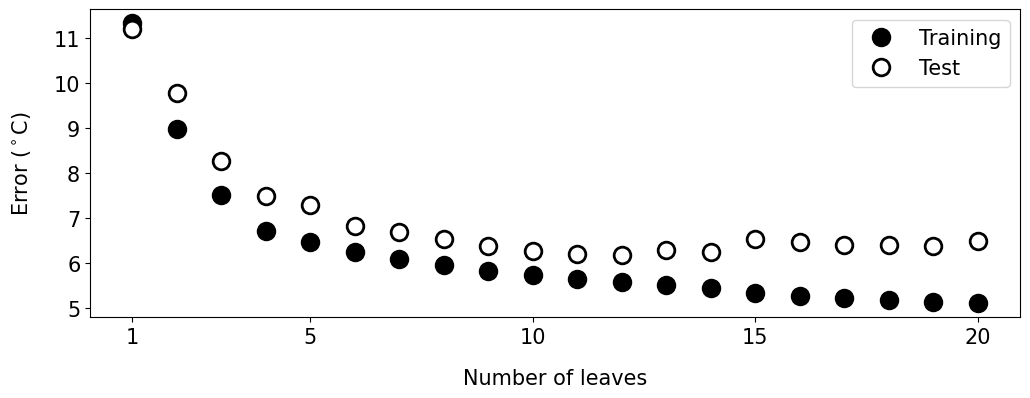

In [68]:
split_inds = np.arange(0,n_splits+1,1)
msize=12
medgewidth=2
leave_inds = split_inds+1
plt.figure(figsize=(12,4))
plt.xticks([1,5,10,15,20],fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(leave_inds,np.sqrt(MSE_2015_splits),color="black",markersize=msize, 
                 marker='o', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                 label="Training")
plt.plot(leave_inds,np.sqrt(MSE_2016_splits),color="white",markersize=msize, 
                 marker='o',markeredgewidth=medgewidth, ls = 'None',markeredgecolor="black",
                 label="Test")
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 15)
plt.xlabel(r'Number of leaves',fontsize=font_size,labelpad = 15)
plt.legend(fontsize=font_size);